# Quality control and filtering scRNA-seq data with ScanPy
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script performs the initial quality control and filtering for a single scRNA-seq sample. The input should be an h5 file that can be read in using the read_10x_h5 command from ScanPy. The output is a filtered AnnData object that can be used for downstream analysis.

In [14]:
# Imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
# Functions
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [40]:
# Paths
input_h5ad_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/processed/24Oct23/cellranger/H1-D39/outs/filtered_feature_bc_matrix.h5"
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/25Oct23/scanpy"
metadata_path = None

In [54]:
# Define run parameters
metadata_source = "cellranger"
output_prefix = "1_qc_scRNAseq"
total_counts_nmads = 3
n_genes_by_counts_nmads = 3
n_top_genes = 20
pct_counts_in_top_genes_nmads = 3
pct_counts_mt_nmads = 3
pct_counts_mt_threshold = 8
nfeatures_low_threshold = 500
nfeatures_high_threshold = 7000
min_cells = None

In [55]:
# Read in single h5 file
adata = sc.read_10x_h5(input_h5ad_path)
adata.var_names_make_unique()
adata

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5603 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [56]:
# If dealing with raw data, filter out empty droplets
if adata.n_obs > 100000:
    sc.pp.filter_cells(adata, min_genes=20)

In [57]:
# Add in CellRanger metadata if applicable
if metadata_path is not None:
    if metadata_source is None:
        metadata_source = os.path.basename(metadata_path).split(".")[0]
    metadata = pd.read_csv(metadata_path, index_col=0)
    metadata.columns = [c + "_" + metadata_source for c in metadata.columns]
    adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

In [58]:
# Define mito genes and ribosomal genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [59]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 5603 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


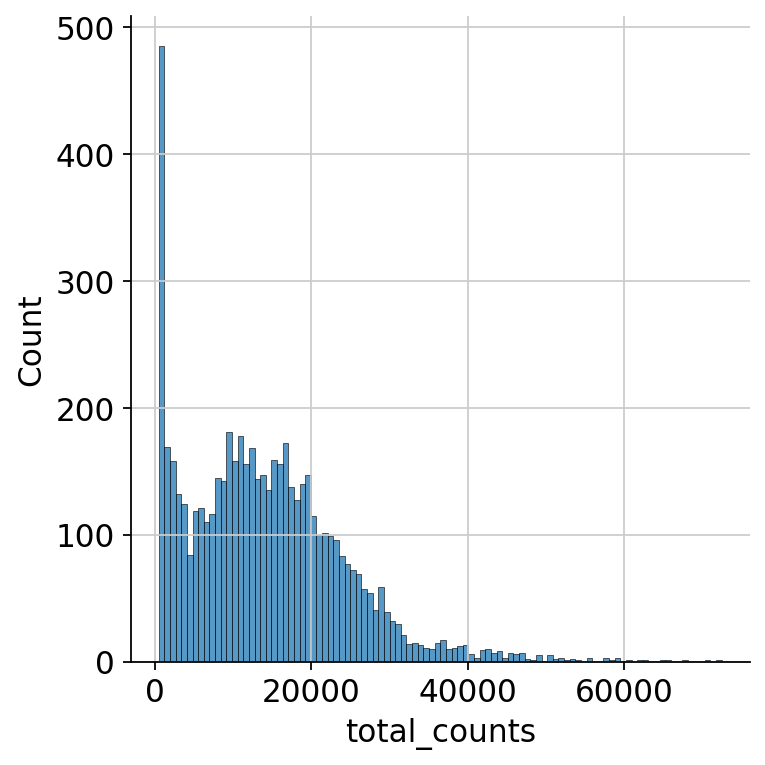

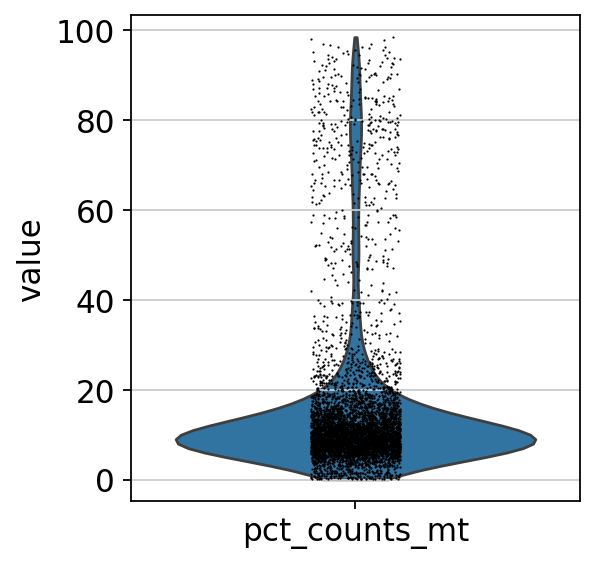

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


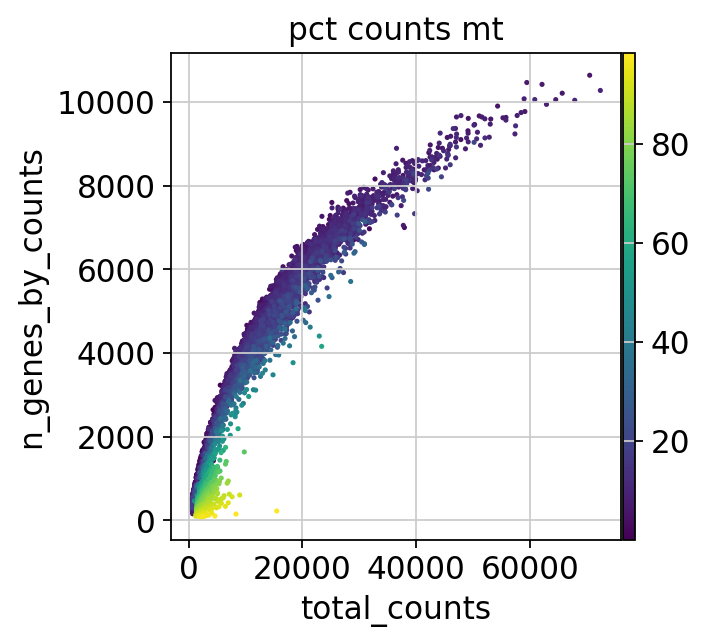

In [60]:
# Plots of QC metrics
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [61]:
# Define outliers either by MADs or by user-defined thresholds
if nfeatures_high_threshold is not None or nfeatures_low_threshold is not None:
    if nfeatures_high_threshold is None:
        nfeatures_high_threshold = np.inf
    if nfeatures_low_threshold is None:
        nfeatures_low_threshold = -np.inf
    adata.obs["outlier"] = (adata.obs["n_genes_by_counts"] < nfeatures_low_threshold) | (adata.obs["n_genes_by_counts"] > nfeatures_high_threshold)
else:
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", total_counts_nmads)
        | is_outlier(adata, "log1p_n_genes_by_counts", n_genes_by_counts_nmads)
        | is_outlier(adata, "pct_counts_in_top_20_genes", pct_counts_in_top_genes_nmads)
    )
adata.obs.outlier.value_counts()

outlier
False    4610
True      993
Name: count, dtype: int64

In [62]:
# Define mt outliers, either by MADs or by user-defined thresholds
if nfeatures_high_threshold is not None or nfeatures_low_threshold is not None:
    adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > pct_counts_mt_threshold)
else:
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", pct_counts_mt_nmads) | (
        adata.obs["pct_counts_mt"] > pct_counts_mt_threshold
    )
adata.obs.mt_outlier.value_counts()

mt_outlier
True     3753
False    1850
Name: count, dtype: int64

In [63]:
# Start a cell log
cell_log = dict(starting_barcodes=adata.n_obs)

In [64]:
# Actually filter the data
print(f"Total number of cells: {adata.n_obs}")
filter_mask = (~adata.obs.outlier) & (~adata.obs.mt_outlier)
filtered_bc = adata.obs[~filter_mask].index
adata = adata[filter_mask].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 5603
Number of cells after filtering of low quality cells: 1439


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [65]:
# Save the filtered barcodes as a text file
filtered_bc_path = os.path.join(outdir_path, "qc_filtered_barcodes.txt")
filtered_bc.to_series().to_csv(filtered_bc_path, sep="\t", index=False, header=False)

In [66]:
# Add to cell log
cell_log["num_barcodes_after_qc"] = adata.n_obs

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


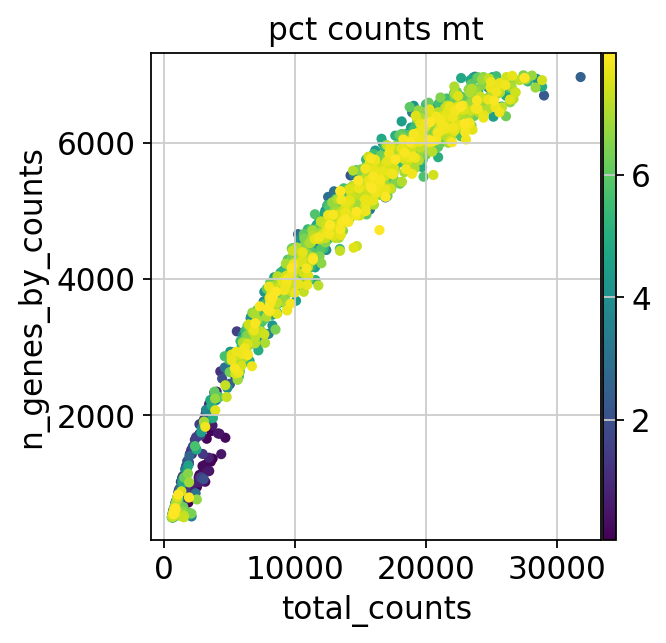

In [67]:
# Plot QC metrics after filtering
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [68]:
# If output directory does not exist, create it.
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [69]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, f"{output_prefix}.h5ad"))

In [73]:
# Create a gene log
gene_log = dict(starting_genes=adata.n_vars)

In [74]:
# Filter genes if min_cells is provided and add to gene log
if min_cells is not None:
    sc.pp.filter_genes(adata, min_cells=min_cells)
    gene_log["num_genes_after_qc"] = adata.n_vars

In [75]:
# Save gene log
pd.DataFrame.from_dict(gene_log, orient="index").to_csv(
    os.path.join(outdir_path, "gene_log.csv")
)

# DONE!

---

# Scratch

## Test script

```bash
input_h5_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm32a_deep/cellbender_raw_feature_bc_matrix_filtered.h5
outdir_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/08Oct23/cellbender_dm32a

cd /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/scanpy

cmd="python 1_qc_scRNAseq.py \
--input_h5_path $input_h5_path \
--outdir_path $outdir_path"

echo $cmd
```

```bash
input_h5_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/21Jul23/igvf_dm32a_deep/outs/raw_feature_bc_matrix.h5
outdir_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a
metadata_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/21Jul23/igvf_dm32a_deep/outs/per_barcode_metrics.csv

cd /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/scanpy

cmd="python 1_qc_scRNAseq.py \
--input_h5_path $input_h5_path \
--outdir_path $outdir_path \
--metadata_path $metadata_path \
--metadata_source cellranger \
--nfeatures_low_threshold 500 \
--nfeatures_high_threshold 7000 \
--pct_counts_mt_threshold 3"

echo $cmd
```

## Get file names

In [51]:
import glob

In [62]:
cellbender_out = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23"
cellbender_h5s = sorted(glob.glob(os.path.join(cellbender_out, "*", "cellbender*matrix_filtered.h5")))
len(cellbender_h5s), cellbender_h5s

(26,
 ['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm0b_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm11a_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm12b_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm14b_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm21a_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm23a_deep/cellbender_raw_feature_bc_matrix_filtered.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm24a_deep/cellbender_raw_feature_bc_ma

In [57]:
# Remove the cellbender h5s with "pilot"
cellbender_h5s = [x for x in cellbender_h5s if "pilot" not in x]
len(cellbender_h5s), cellbender_h5s

(25,
 ['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm0b_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm11a_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm12b_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm14b_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm21a_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm23a_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/04Oct23/igvf_dm24a_deep/cellbender_raw_feature_bc_matrix.h5',
  '/cellar/users/aklie/data/datasets/igvf_sc

In [61]:
# Extract the sample names
sample_names = [x.split("/")[-2] for x in cellbender_h5s]
sample_names = [i.split("_")[1] for i in sample_names]
sample_names

['dm0b',
 'dm11a',
 'dm12b',
 'dm14b',
 'dm21a',
 'dm23a',
 'dm24a',
 'dm25a',
 'dm31a',
 'dm32a',
 'dm33a',
 'dm34a',
 'dm35a',
 'dm42b',
 'dm43b',
 'dm44a',
 'dm45a',
 'mo14',
 'mo1',
 'mo22',
 'mo26',
 'mo29',
 'mo33',
 'mo38',
 'mo3']

## More metrics

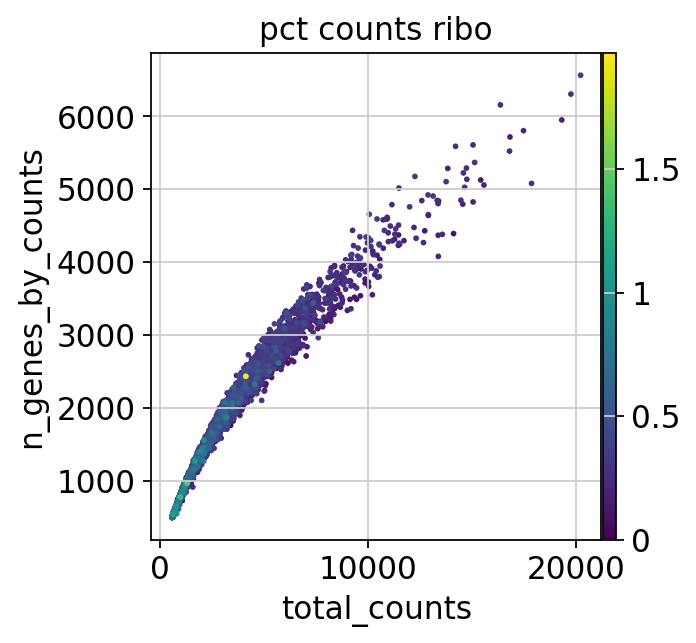

In [44]:
# Plot QC metrics after filtering
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

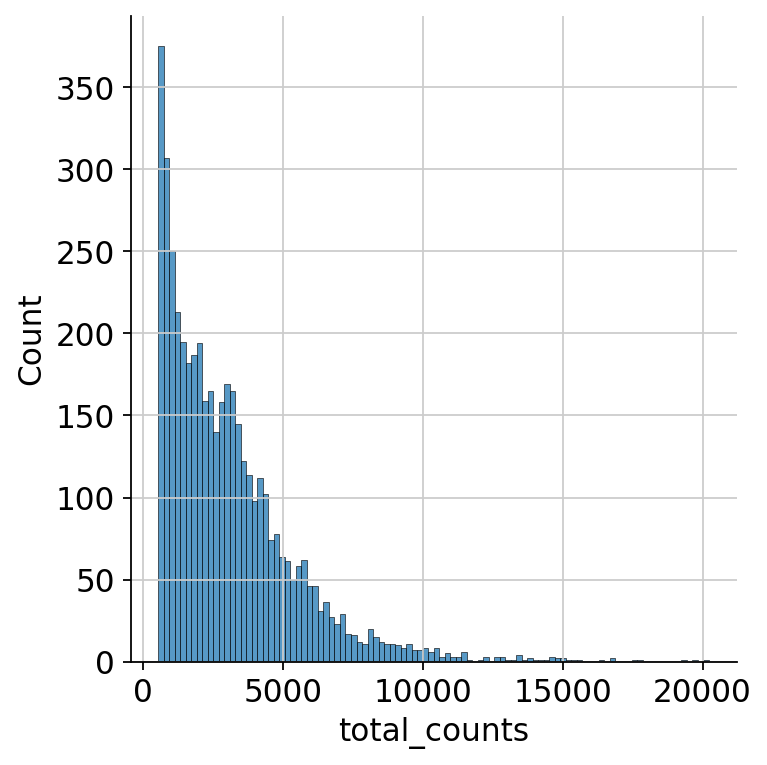

In [45]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)

In [46]:
adata.obs["is_cell_cellranger"].value_counts()

1    4388
0     100
Name: is_cell_cellranger, dtype: int64

In [47]:
adata.obs.columns

Index(['n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger',
       'is_cell_cellranger', 'excluded_reason_cellranger',
       'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger',
       'gex_conf_intergenic_reads_cellranger',
       'gex_conf_exonic_reads_cellranger',
       'gex_conf_intronic_reads_cellranger',
       'gex_conf_exonic_unique_reads_cellranger',
       'gex_conf_exonic_antisense_reads_cellranger',
       'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger',
       'gex_conf_intronic_unique_reads_cellranger',
       'gex_conf_intronic_antisense_reads_cellranger',
       'gex_conf_intronic_dup_reads_cellranger',
       'gex_intronic_umis_cellranger',
       'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger',
       'gex_genes_count_cellranger', 'atac_raw_reads_cellranger',
       'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger',
       'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger',
       'ata

In [48]:
adata.obs["excluded_reason_cellranger"].value_counts()

0    4438
1      47
2       3
Name: excluded_reason_cellranger, dtype: int64

In [49]:
adata.obs["total_counts"].describe()

count     4488.000000
mean      3101.162109
std       2374.344482
min        554.000000
25%       1316.000000
50%       2549.500000
75%       4128.250000
max      20231.000000
Name: total_counts, dtype: float64

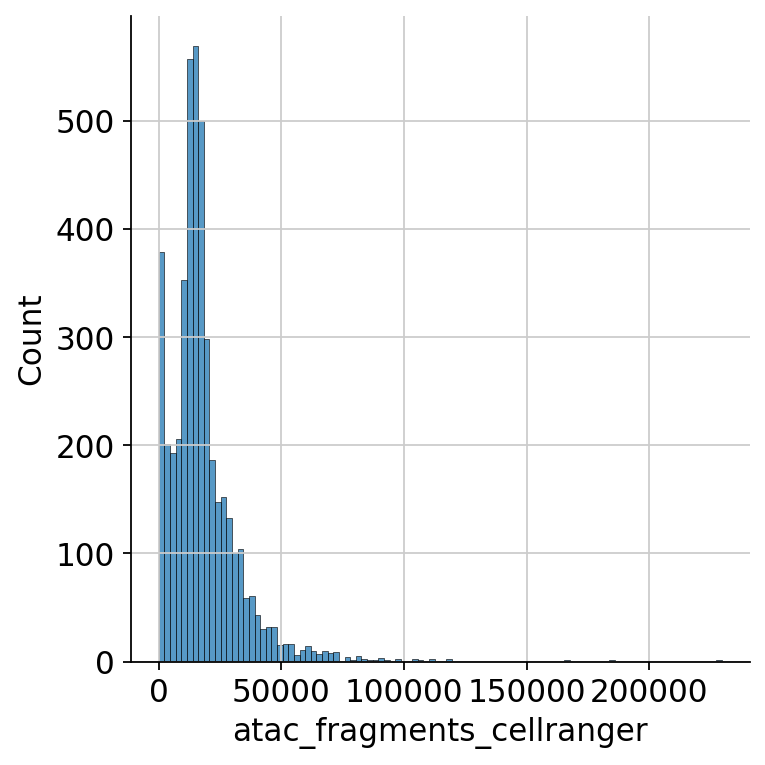

In [50]:
p1 = sns.displot(adata.obs["atac_fragments_cellranger"], bins=100, kde=False)

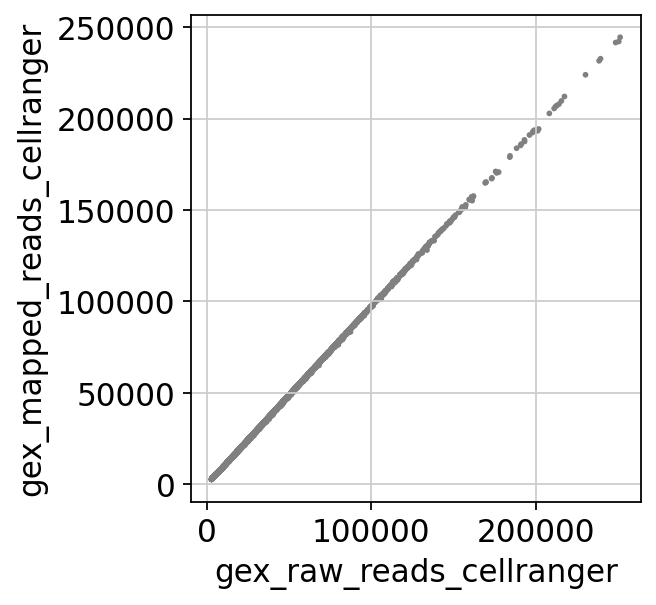

In [51]:
p1 = sc.pl.scatter(adata, 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger')

In [52]:
adata.obs["gex_mapping_pct_cellranger"] = adata.obs["gex_mapped_reads_cellranger"] / adata.obs["gex_raw_reads_cellranger"] * 100

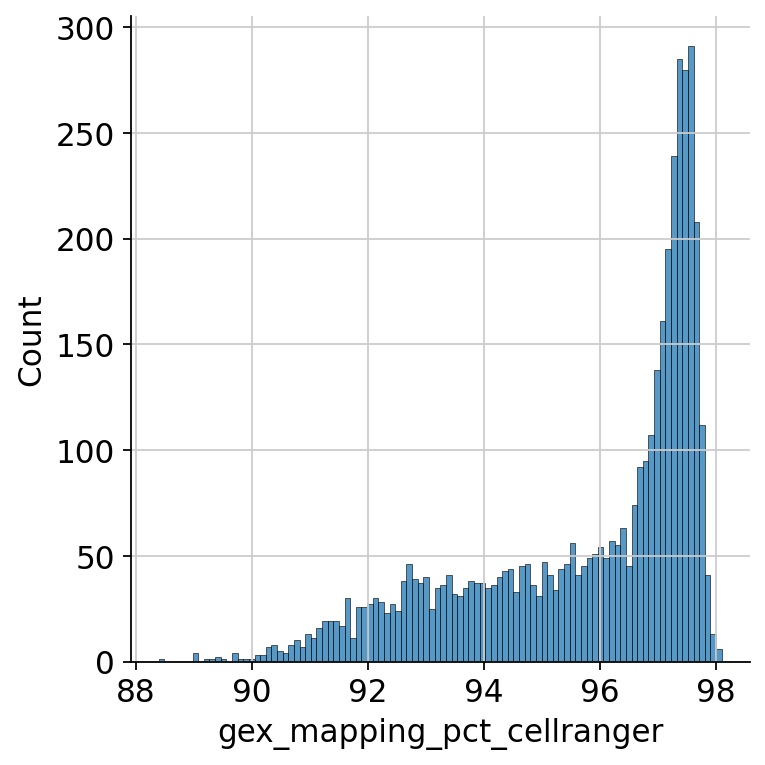

In [53]:
p1 = sns.displot(adata.obs["gex_mapping_pct_cellranger"], bins=100, kde=False)